In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


import os
import glob
from tqdm.notebook import tqdm, trange

# Load

In [2]:
train_df = pd.read_csv('./hms-harmful-brain-activity-classification/train.csv')

processed_train = train_df.groupby('eeg_id')[['patient_id']].agg('first')
class_score_train = train_df.groupby('eeg_id')[train_df.columns[-6:]].agg('sum')
class_score_train[train_df.columns[-6:]] = class_score_train.values / class_score_train.sum(axis=1).values.reshape(-1, 1)

processed_train = pd.concat([processed_train, class_score_train], axis=1)
processed_train = processed_train.reset_index()

In [3]:
processed_train

,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...
17084,4293354003,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17085,4293843368,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000
17086,4294455489,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000
17087,4294858825,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333


In [4]:
EEG_PATH = './hms-harmful-brain-activity-classification/train_eegs/'
COLS_INTEREST = ['Fp1', 'C3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

In [5]:
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, sosfilt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

class EEGDataset(Dataset):
    def __init__(self, csv, eeg_path):
        super().__init__()
        self.csv = csv
        self.eeg_path = eeg_path
        self.eeg_file_paths = glob.glob(self.eeg_path+'*')
        
    def __len__(self):
        return len(self.csv)
    
    def standarize(self, eeg):
        scaler = MinMaxScaler()
        eeg = scaler.fit_transform(eeg)
        
        return eeg
    
    def butter_lowpass_filter(self, eeg):
        filtered_eeg = np.zeros(eeg.shape)
        for i, signal in enumerate(eeg):
            sos = butter(4, 30, output='sos', fs=200)
            filtered_signal = sosfilt(sos, signal)
            
            filtered_eeg[i,:] = filtered_signal
            
        del eeg
        return filtered_eeg
        
    def read_eeg(self, eeg_file_path):
        eeg = pd.read_parquet(eeg_file_path)
        
        imputer = SimpleImputer()
        eeg = imputer.fit_transform(eeg)
        #eeg = eeg.values
        eeg = self.standarize(eeg)
        eeg = eeg.T
        
        #select slice of len 10_000
        offset = int((np.clip(np.random.randn(), -2, 2) + 2)*(eeg.shape[1] - 10_000) / 4)
        eeg = eeg[:, offset:offset+10_000]
        
        #clean eeg
        eeg = self.butter_lowpass_filter(eeg)
        
        eeg = np.expand_dims(eeg, axis=0)
        
        return eeg 
    
    def __getitem__(self, idx):
        y = self.csv.loc[idx, self.csv.columns[-6:]].values.reshape(-1,)
        eeg_id = self.csv.loc[idx, 'eeg_id']
        
        eeg_file_path = self.eeg_path + str(eeg_id) + '.parquet'
        X = self.read_eeg(eeg_file_path)
        
        return X, y
        
        
dataset = EEGDataset(processed_train, EEG_PATH)
X, y = dataset[10]
X.shape, y.shape

((1, 20, 10000), (6,))

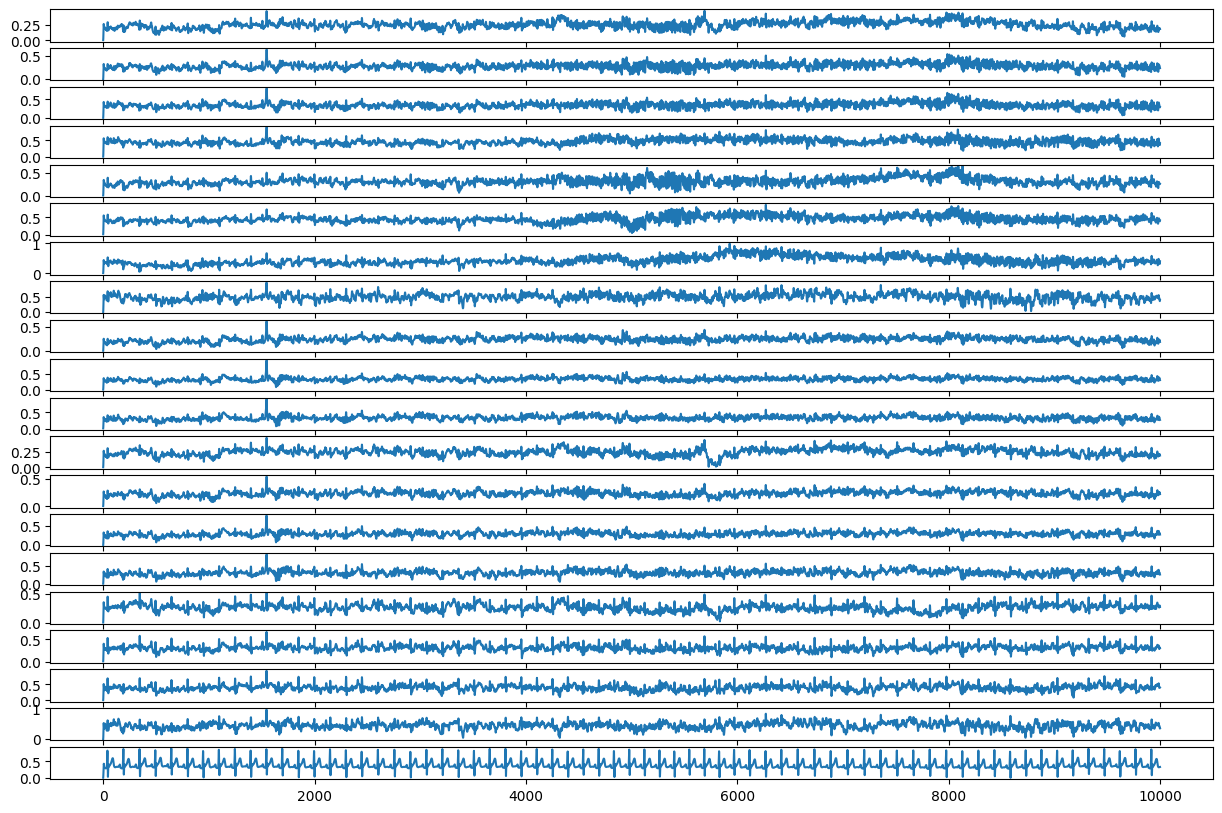

In [6]:
X,_ = dataset[100]

plt.subplots(20, 1, figsize=(15, 10))
for i, signal in enumerate(X[0,:,:]):
    plt.subplot(20, 1, i+1)
    plt.plot(signal)
# plt.plot(X[0,:,:].T)
# plt.show()    

# Model

In [7]:
import torch.nn as nn

class EEGNetSelf(nn.Module):
    def __init__(self, Chans = 20, Samples = 10000, dropoutRate = 0.5, kernLength = 100, F1 = 8, D = 2, F2 = 16, num_Class=6):
        super().__init__()
        self.conv1 = nn.Conv2d(1,F1,(1, kernLength),padding='same',bias=False)
        self.batch1 = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(F1,F1*D,(Chans,1),padding='valid',groups=F1,bias=False)
        self.batch2 = nn.BatchNorm2d(F1*D)
        self.elu = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1,4))
        self.dropout = nn.Dropout2d(dropoutRate)
        self.conv3 = nn.Sequential(
            nn.Conv2d(F1*D,F1*D,(1,16),padding='same',groups=F1*D,bias=False),
            nn.Conv2d(F1*D,F2,(1,1),padding='same',bias=False)
        )
        self.batch3 = nn.BatchNorm2d(F2)
        self.poooling2 = nn.AvgPool2d((1,8))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4992,num_Class)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.elu(x)
        x = self.pooling1(x)
        x = self.dropout(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.elu(x)
        x = self.poooling2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.logsoftmax(x)
        return x        

model = EEGNetSelf().to(device)
from torchsummary import summary
summary(model, (1, 20, 10000))
        
        


/home/qingtang/.conda/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 8, 20, 10000]             800
       BatchNorm2d-2         [-1, 8, 20, 10000]              16
            Conv2d-3         [-1, 16, 1, 10000]             320
       BatchNorm2d-4         [-1, 16, 1, 10000]              32
               ELU-5         [-1, 16, 1, 10000]               0
         AvgPool2d-6          [-1, 16, 1, 2500]               0
         Dropout2d-7          [-1, 16, 1, 2500]               0
            Conv2d-8          [-1, 16, 1, 2500]             256
            Conv2d-9          [-1, 16, 1, 2500]             256
      BatchNorm2d-10          [-1, 16, 1, 2500]              32
              ELU-11          [-1, 16, 1, 2500]               0
        AvgPool2d-12           [-1, 16, 1, 312]               0
        Dropout2d-13           [-1, 16, 1, 312]               0
          Flatten-14                 [-

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_df, test_val_df = train_test_split(processed_train, test_size=0.25)
test_df, val_df = train_test_split(test_val_df, test_size=0.5)

train_data = EEGDataset(train_df.reset_index(), EEG_PATH)
test_data = EEGDataset(test_df.reset_index(), EEG_PATH)
val_data = EEGDataset(val_df.reset_index(), EEG_PATH)

train_data = DataLoader(train_data, batch_size=64)
test_data = DataLoader(test_data, batch_size=64)
val_data = DataLoader(val_data, batch_size=64)

len(train_data), len(test_data), len(val_data)

(201, 34, 34)

In [24]:
from torch.optim import Adam
lr = 1e-5
optimizer = Adam(model.parameters(), lr)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
criterion = nn.KLDivLoss(reduction='mean')

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
EPOCHS=30

for epoch in trange(EPOCHS):
    for i, (X, y) in enumerate(tqdm(train_data)):
        
        X, y = X.to(device), y.to(device)
        X, y = X.to(torch.float), y.to(torch.float) 
        model.train()
        optimizer.zero_grad()
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        if i%100==0:
            print(loss)
        
    avg_loss = 0    
    for X, y in tqdm(val_data):
        X, y = X.to(torch.float), y.to(torch.float)
        X, y = X.to(device), y.to(device)
        model.eval()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        avg_loss += loss.detach().cpu().numpy()

    scheduler.step(avg_loss / len(val_data))
    print(f'EHOCH:{epoch}, VAL_LOSS: {avg_loss / len(val_data)}')


In [ ]:
torch.save(model.state_dict(),"./model_Mar20.h5")

In [20]:
test_predictions = []
test_truth = []
with torch.inference_mode():
    for i,(X,y) in enumerate(tqdm(test_data)):
        X, y = X.to(device), y.to(device)
        X, y = X.to(torch.float), y.to(torch.float) 
        prediction = model(X)
        test_predictions.append(prediction)
        test_truth.append(y)



  0%|          | 0/34 [00:00<?, ?it/s]